In [1]:
using Plots            # To generate figures
using JuMP             
using Cbc              # Solver used
using JLD2             # File input and output

## Exercise 11.2 - Capacitated vehicle routing problem (CVRP)

### Background

Consider a centralised depot, from which deliveries are supposed to be made from. The delivers have to be made to a number of clients, and each client has a specific demand. Some assumptions we will consider:

* The deliveries have to be made by vehicles that are of limited capacity; 
* Multiple routes are created, and a single vehicle is assignmed to each route; 
* We assume that the number of vehicles is not a limitation.

Our objective is to define **optimal routes** such that the total distance travelled is minimised.

### Problem structure and input data

Let us define the elements that form our problem. You will notice that we use a graph-based notation, referring to elements such as arcs and nodes.

#### Structural elements
* $n$ is the total number of clients
* $N$ is the *set* of clients, with $N = \{2, \dots, n+1\}$
* $V$ is the set of *nodes*, representing a depot (node 1) and the clients (nodes $i \in N$). Thus $V = \{1\} \cup N$.
* $A$ is a set of *arcs*, with $A = \{(i,j) \in V \times V : i \neq j\}$

#### Parameters (input data structure)
* $C_{i,j}$ - cost of travelling via arc $(i,j) \in A$ (equals distance between $i$ and $j$);
* $Q$ - vehicle capacity in units;
* $D_i$ - amount that has to be delivered to customer $i \in N$, in units;

In [2]:
# Problem structural elements
struct Instance
   n     # Total of nodels
   N     # Set of client nodes
   V     # Set of all nodes, including depot
   A     # Set of arcs
   loc_x # x-coordinates of all points
   loc_y # y-coordinates of all points
   Q     # vehicle capacity
   D     # demand at the node (to be delivered)
   C     # arc trasversal cost
   bigM  # A suitable big M value to be used in all big M constraints
end

In [3]:
f = jldopen("ex11_ins.jld2")
ins = nothing
try
    ins = f["ins"]
finally
    close(f)
end;

The cell below shows a plot of the problem, indicting demands and time windows.

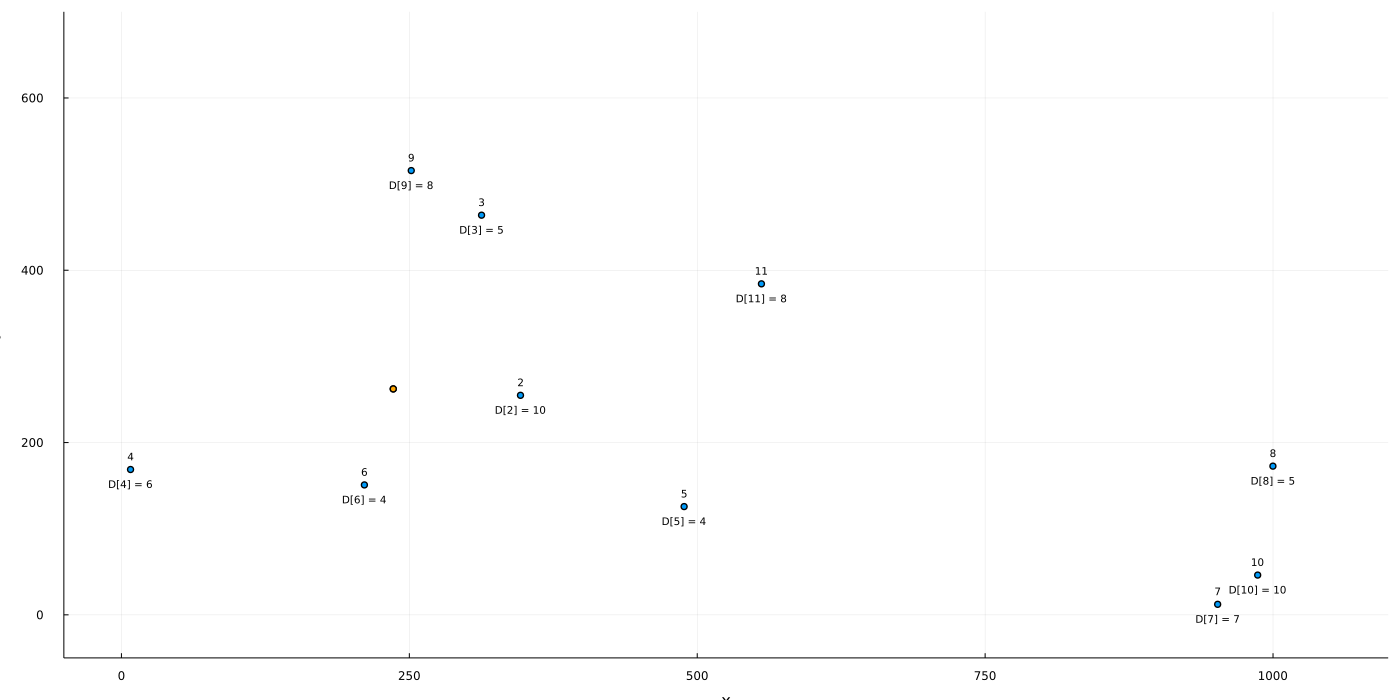

In [4]:
## Plotting nodes

scatter(ins.loc_x, ins.loc_y,
    legend = false,
    size = (1400,700),
    xaxis = ("x", (-50.0,1100.0)),
    yaxis = ("y", (-50.0,700.0)),
)

for i in ins.N
    annotate!(ins.loc_x[i], ins.loc_y[i] +15, ("$i", 7))
    
    ## These make the plot somewhat hard to read
    annotate!(ins.loc_x[i], ins.loc_y[i] - 17, ("D[$(i)] = $(ins.D[i])", 7))
end

scatter!((ins.loc_x[1], ins.loc_y[1]), color=:orange)

### Item (a)

If we allow multiple departures and arrivals for the depot node and each client node is visited exactly once, we end up with a 
MIP formulation:

\begin{align}
    \min & \sum_{(i,j) \in A} C_{i,j}x_{i,j} \\
    \text{s.t.: } & \sum_{j \in V, j \neq i} x_{i,j} = 1, \ \forall i \in N  \\
    & \sum_{i \in V, i \neq j} x_{i,j} = 1, \ \forall j \in N  \\
    & u_i - D_j \leq u_j + M*( 1 - x_{i,j}) , \ \forall i \in V, j \in N \\
    & u_i - D_j \geq u_j - M*( 1 - x_{i,j}) , \ \forall i \in V, j \in N \\
    & 0 \leq u_i \leq Q, \ \forall i \in V  \\
    & u_1 = Q \\
    & x_{i,j} \in \{0,1\}, \ \forall i \in V, \forall j \in V
\end{align}

We use variables $x_{i,j}$ for modelling whether the arc $(i,j)$ is "active" in the solution. If $x_{i,j}=1$, the arc $(i,j)$ is active, meaning that there is a vehicle going from node $i$ to node $j$. The objective function $\sum_{(i,j) \in A} C_{i,j}x_{i,j}$ represents the total cost of moving along the active arcs in the solution. The next two constraints $\sum_{j \in V, j \neq i} x_{i,j} = 1, \ \forall i \in N$ and $\sum_{i \in V, i \neq j} x_{i,j} = 1, \ \forall j \in N$ state that each node in $N$ (the set of *client* nodes) must be visited exactly once. A visit is defined as a vehicle entering and leaving that node. So far, this should be familiar, these same ideas would be found in a TSP formulation.

The differences between the capacitated vehicle routing problem (CVRP) and travelling salesperson problems (TSP) are
1. We have multiple vehicles available instead of a single salesperson
2. The vehicles have a limited capacity

To model the limited capacity, we introduce variables $u_i$, representing the remaining cargo in a vehicle when leaving a node $i$. We assume that all vehicles leave the depot full of cargo ($U_1 = Q$). We then want a constraint saying that if a vehicle goes from node $i \in V$ to node $j \in N$, the amount of cargo in the vehicle must decrease by $D_j$. For this, we use two big-M constraints $u_i - D_j \leq u_j + M*( 1 - x_{i,j}) , \ \forall i \in V, j \in N$ and $u_i - D_j \geq u_j - M*( 1 - x_{i,j}) , \ \forall i \in V, j \in N$. When combined, these result in something like:
$$ x_{i,j}=1 \Rightarrow u_i - D_j = u_j$$
$$ x_{i,j}=0 \Rightarrow -\infty \le u_i - D_j - u_j \le \infty$$

The second line can also be written as $ x_{i,j}=0 \Rightarrow u_i - D_j - u_j \in \mathbb{R}$, meaning that there is no relationship between $u_i$ and $u_j$.
#' 
### Item (b)
Complete the function `create_VRP_model()` below to implement the CVRP model.

In [ ]:
function create_VRP_model(ins; max_time = 300)
    
    n = ins.n          # Number of client nodes
    N = ins.N          # Set of client nodes
    V = ins.V          # Set of all nodes, including depot
    A = ins.A          # Set of arcs
    loc_x = ins.loc_x  # x-coordinates of all points
    loc_y = ins.loc_y  # y-coordinates of all points
    Q = ins.Q          # Vehicle capacity
    D = ins.D          # Demand at the node (to be delivered)
    C = ins.C          # Arc traversal cost 
    bigM = ins.bigM    # A large enough big M value to be used in all big M constraints
    
    model = Model(Cbc.Optimizer)                # Declaring the model object.
    set_optimizer_attribute(model, "seconds", max_time)

    # Declare decision variables
    @variable(model, x[i in V, j in V], Bin) 
    @variable(model, 0 <= u[i in V] <= Q)
    @constraint(model, u[1]==Q)
    
    # Objective function
    @objective(model, Min, sum(C[i,j] * x[i,j] for (i,j) in A))

    # Constraints
    @constraint(model, c1[i in N], sum(x[i,j] for j in V if j != i) == 1)
    @constraint(model, [j in N], sum(x[i,j] for i in V if i != j) == 1)
    @constraint(model, [i in V, j in N], u[i] - D[j] <= u[j] + bigM * (1 - x[i,j]))
    @constraint(model, [i in V, j in N], u[i] - D[j] >= u[j] - bigM * (1 - x[i,j]))
    
    return model
end

In [ ]:
## Create the basic model and optimise it
basic_model = create_VRP_model(ins; max_time = 300)
optimize!(basic_model)

The cell below shows a plot of the solution.

In [ ]:
## Retrieving active arcs. 
active_arcs = [(i,j) for (i,j) in ins.A if value.(basic_model[:x])[i,j] >= 1-(1E-9)]

scatter(ins.loc_x, ins.loc_y,
    legend = false,
    size = (1100,700),
    xaxis = ("x", (-10.0,1100.0)),
    yaxis = ("y", (-10.0,700.0)),
)

for i in ins.N
    annotate!(ins.loc_x[i], ins.loc_y[i] +30, ("D[$i]=$(ins.D[i])", 7))
    annotate!(ins.loc_x[i], ins.loc_y[i] +15, ("u[$i]=$(round(value.(basic_model[:u])[i], digits=1))", 7))
end

## Plotting the arcs
for (i,j) in active_arcs
    quiver!([ins.loc_x[i]], [ins.loc_y[i]], quiver=([ins.loc_x[j] - ins.loc_x[i]], [ins.loc_y[j] - ins.loc_y[i]]), 
        color = 1
    )
end

scatter!((ins.loc_x[1], ins.loc_y[1]), color=:orange)

## Exercise 11.1 - Preprocessing and primal heuristics
#' 
### b) RINS and RENS for UFL-W

From exercise 9: Let $N = \{1,\dots,n\}$ be a set of potential facilities and $M = \{1,\dots,m\}$ a set of clients. Let $y_j = 1$ if facility $j$ is opened, and $y_j = 0$ otherwise. Moreover, let $x_{ij}$ be the fraction of client $i$'s demand satisfied from facility $j$. The UFL can be formulated as the mixed-integer problem (MIP): 

$$\begin{align}
 \text{(UFL-W)} : \quad &\min_{x,y} \sum_{j\in N} f_jy_j + \sum_{i\in M}\sum_{j\in N} c_{ij}x_{ij}\\
       &\text{s.t.} \\
       &\quad \sum_{j\in N}x_{ij} = 1, &\forall i \in M,\\
       &\quad \sum_{i\in M}x_{ij} \leq my_j, &\forall  j \in N,\\
       &\quad x_{ij} \geq 0, &\forall i \in M, \forall j \in N,\\
       &\quad y_j \in \{0,1\}, &\forall j\in N,
\end{align}$$

where $f_j$ is the cost of opening facility $j$, and $c_{ij}$ is the cost of satisfying client $i$'s demand from facility $j$. Consider an instance (different from exercise 9) of the UFL with opening costs $f=(21,16,30,24,11)$ and client costs

$$\begin{align*}
 (c_{ij}) = \left(
	\begin{array}{ccccc}
		6  & 9  & 3 & 4  & 12 \\
		1  & 2  & 4 & 9  & 2  \\
		15 & 2  & 6 & 3  & 18 \\
		9  & 23 & 4 & 8  & 1  \\
		7  & 11 & 2 & 5  & 14 \\
		4  & 3  & 10& 11 & 3
	\end{array}
 \right)
\end{align*}$$

In [ ]:
f = [21 16 30 24 11] # Facility opening costs
c = [6 9 3 4 12; 1 2 4 9 2; 15 2 6 3 18; 9 23 4 8 1; 7 11 2 5 14; 4 3 10 11 3] # Cost of satisfying demand
(m, n) = size(c)
M = 1:m # Set of clients
N = 1:n;# Set of facilities

#### Obtain MIP solution for comparison

In [ ]:
ufl_w = Model(Cbc.Optimizer)

@variable(ufl_w, x[M,N] >= 0) # Fraction of demand (client i) satisfied by facility j
@variable(ufl_w, y[N], Bin)   # Facility location

# Minimize total cost
@objective(ufl_w, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N)) 

# For each client, the demand must be fulfilled
@constraint(ufl_w, demand[i in M], sum(x[i,j] for j in N) == 1)
# A big-M style constraint stating that facility j can't send out anything if y[j]==0
@constraint(ufl_w, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])

optimize!(ufl_w)

In [ ]:
println("UFL-W MILP:")
println("Optimal value $(objective_value(ufl_w))")
println("with y = $(value.(y).data)")

#### Obtain LP relaxation solution for heuristics

In [ ]:
ufl_w_rel = Model(Cbc.Optimizer)

@variable(ufl_w_rel, x[M,N] >= 0) # Fraction of demand (client i) satisfied by facility j
@variable(ufl_w_rel, 0<=y[N]<=1)  # Facility location

# Minimize total cost
@objective(ufl_w_rel, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N)) 

# For each client, the demand must be fulfilled
@constraint(ufl_w_rel, demand[i in M], sum(x[i,j] for j in N) == 1)
# A big-M style constraint stating that facility j can't send out anything if y[j]==0
@constraint(ufl_w_rel, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])

optimize!(ufl_w_rel)

In [ ]:
println("UFL-W LP:")
println("Optimal value $(objective_value(ufl_w_rel))")
println("with y = $(value.(y).data)")

#### RINS
We are given a primal feasible solution $\bar{y}=(1,0,0,0,0)$ for starting RINS. The solution for this UFL-W LP relaxation is $y^{LP} = (0, 1/6, 1/3, 0, 1/2)$.

In [ ]:
y_bar = [1,0,0,0,0]
y_lp = [0, 1/6, 1/3, 0, 1/2]

ufl_rins = Model(Cbc.Optimizer)

@variable(ufl_rins, x[M,N] >= 0) # Fraction of demand (client i) satisfied by facility j
@variable(ufl_rins, y[N], Bin)   # Facility location

# Minimize total cost
@objective(ufl_rins, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N)) 

# For each client, the demand must be fulfilled
@constraint(ufl_rins, demand[i in M], sum(x[i,j] for j in N) == 1)
# A big-M style constraint stating that facility j can't send out anything if y[j]==0
@constraint(ufl_rins, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])

# Fixing variables that have the same value in our primal feasible solution and the LP relaxation
# TODO: add your code here

optimize!(ufl_rins)

In [ ]:
println("UFL-W RINS solution:")
println("Optimal value $(objective_value(ufl_rins))")
println("with y = $(value.(y).data)")

#### RENS
RINS gave us a pretty good solution, let's see what happens with RENS.

In [ ]:
y_lp = [0, 1/6, 1/3, 0, 1/2]

ufl_rens = Model(Cbc.Optimizer)

@variable(ufl_rens, x[M,N] >= 0) # Fraction of demand (client i) satisfied by facility j
@variable(ufl_rens, y[N], Bin)   # Facility location

# Minimize total cost
@objective(ufl_rens, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N)) 

# For each client, the demand must be fulfilled
@constraint(ufl_rens, demand[i in M], sum(x[i,j] for j in N) == 1)
# A big-M style constraint stating that facility j can't send out anything if y[j]==0
@constraint(ufl_rens, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])

# Fixing variables that have an integer solution in the LP relaxation
# TODO: add your code here

optimize!(ufl_rens)

In [ ]:
println("UFL-W RENS solution:")
println("Optimal value $(objective_value(ufl_rens))")
println("with y = $(value.(y).data)")

In this case, RINS and RENS gave the same solution, but RINS depends on the initial feasible solution provided.